In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, KFold, cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer, LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
import statsmodels.api as sm
from sklearn.svm import SVR
from catboost import CatBoostRegressor

import time
import warnings
from tqdm.notebook import tqdm

from __future__ import annotations
from typing import Iterable, Optional, List, Dict, Tuple
from sklearn.base import BaseEstimator, TransformerMixin

In [10]:
Ames_original = pd.read_csv('Ames_HousePrice.csv', index_col=0)

Ames = Ames_original.copy()

# Hardcode NAN encoding where appropriate

bath_cols = ["FullBath", "HalfBath", "BsmtFullBath", "BsmtHalfBath"]
Ames[bath_cols] = Ames[bath_cols].fillna(0)

garage_cols = ['GarageArea', 'GarageCars']
Ames[garage_cols] = Ames[garage_cols].fillna(0)

basement_cols = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']
Ames[basement_cols] = Ames[basement_cols].fillna(0)

Ames['MasVnrArea'] = Ames['MasVnrArea'].fillna(0)
Ames['PoolArea'] = Ames['PoolArea'].fillna(0)

# Convert the below numeric features to categorical features
Ames['MSSubClass'] = Ames['MSSubClass'].astype('object')
Ames['YrSold'] = Ames['YrSold'].astype('object')
Ames['MoSold'] = Ames['MoSold'].astype('object')

In [11]:
X_fe = Ames.copy()

# Targeted Feature Engineering
X_fe["TotalSF"] = X_fe["GrLivArea"] + X_fe["TotalBsmtSF"]
X_fe["HouseAgeSinceRemod"] = X_fe["YrSold"].astype(int) - X_fe["YearRemodAdd"].astype(int)

HalfBath_coeff = 0.48
BsmtFullBath_coeff = 1.18
BsmtHalfBath_coeff = 0.1
                         

X_fe['TotalBaths'] = (X_fe['FullBath'] + 
                      HalfBath_coeff * X_fe['HalfBath'] + 
                      BsmtFullBath_coeff * X_fe['BsmtFullBath'] + 
                      BsmtHalfBath_coeff * X_fe['BsmtHalfBath'])


# Add Interactions
X_fe['TotalSF_x_Qual'] = X_fe['TotalSF'] * X_fe['OverallQual']

X_fe = X_fe.drop(columns=['SalePrice','PID'])
y = Ames['SalePrice']

In [12]:
def _patch_ct(ct: ColumnTransformer):
    try:
        params = ct.get_params(deep=False)
        if "force_int_remainder_cols" in params:
            val = params["force_int_remainder_cols"]
            if val == "deprecated" or not isinstance(val, (bool,)):
                ct.set_params(force_int_remainder_cols=False)
    except Exception:
        if hasattr(ct, "__dict__") and "force_int_remainder_cols" in ct.__dict__:
            del ct.__dict__["force_int_remainder_cols"]

def patch_sklearn_objects(obj):
    if isinstance(obj, ColumnTransformer):
        _patch_ct(obj)
        for _, trans, _ in getattr(obj, "transformers", []):
            if isinstance(trans, (Pipeline, ColumnTransformer)):
                patch_sklearn_objects(trans)
        return obj

    if isinstance(obj, Pipeline):
        for _, step in obj.steps:
            if isinstance(step, (Pipeline, ColumnTransformer)):
                patch_sklearn_objects(step)
        return obj

    for attr in ("named_steps", "_final_estimator"):
        if hasattr(obj, attr):
            sub = getattr(obj, attr)
            try:
                patch_sklearn_objects(sub)
            except Exception:
                pass
    return obj

In [14]:
# === ONE-CELL START: encoders + pipelines + CV helper (no-TTR, short params) ===
# ----------------------------- Ordinal maps -----------------------------
ORDINAL_ORDER: Dict[str, List[str]] = {
    'Electrical': ['Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],
    'LotShape': ['IR3', 'IR2', 'IR1', 'Reg'],
    'Utilities': ['ELO', 'NoSeWa', 'NoSewr', 'AllPub'],
    'LandSlope': ['Sev', 'Mod', 'Gtl'],
    'ExterQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'ExterCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtExposure': ['None', 'No', 'Mn', 'Av', 'Gd'],
    'BsmtFinType1': ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'BsmtFinType2': ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'HeatingQC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'KitchenQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Functional': ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
    'FireplaceQu': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageFinish': ['None', 'Unf', 'RFn', 'Fin'],
    'GarageQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'PavedDrive': ['N', 'P', 'Y'],
    'PoolQC': ['None', 'Fa', 'TA', 'Gd', 'Ex'],
    'Fence': ['None', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']
}

# --------------------- Utilities (metrics + helpers) --------------------
def rmse(y_true, y_pred) -> float:
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

from pandas.api.types import CategoricalDtype
def _is_object_like(s: pd.Series) -> bool:
    return s.dtype.kind in ("O", "b") or isinstance(s.dtype, CategoricalDtype)

# --------------------------- Quantile capper ----------------------------
class QuantileCapper(BaseEstimator, TransformerMixin):
    def __init__(self, lower_q: float = 0.01, upper_q: float = 0.99):
        self.lower_q = lower_q
        self.upper_q = upper_q

    def fit(self, X, y=None):
        df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
        self.feature_names_in_ = list(df.columns)
        self.lower_ = df.quantile(self.lower_q)
        self.upper_ = df.quantile(self.upper_q)
        return self

    def transform(self, X):
        df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X, columns=self.feature_names_in_)
        df = df.clip(self.lower_, self.upper_, axis=1)
        return df.infer_objects(copy=False)   # <--- this silences the warning

    def get_feature_names_out(self, input_features=None):
        return np.asarray(self.feature_names_in_, dtype=object)

# ------------------------- Preprocessor builder -------------------------
def build_preprocessor(
    df: pd.DataFrame,
    *,
    mode: str = "linear",  # 'linear' -> log/scale; 'tree' -> no log/scale on numerics
    numeric_cap: Optional[Iterable[str]] = None,
    lower_q: float = 0.01,
    upper_q: float = 0.99,
    log_cols: Optional[Iterable[str]] = None,          # (linear mode only)
    scale_features: Optional[Iterable[str]] = None,    # (linear mode only)
    zero_impute_cols: Optional[Iterable[str]] = None   # exact zeros for these numerics
) -> ColumnTransformer:

    if mode not in {"linear", "tree"}:
        raise ValueError("mode must be 'linear' or 'tree'")

    num_all = df.select_dtypes(include=["number"]).columns.tolist()
    cat_all = [c for c in df.columns if _is_object_like(df[c])]

    ordinal_explicit = [c for c in ORDINAL_ORDER.keys() if c in df.columns and c != "Electrical"]
    nominal_all = [c for c in cat_all if c not in ORDINAL_ORDER.keys()]

    zero_impute_cols = list(zero_impute_cols or ["BsmtFullBath", "BsmtHalfBath"])
    zero_impute_cols = [c for c in zero_impute_cols if c in num_all]

    default_cap = [
        "LotArea","LotFrontage","MasVnrArea","TotalBsmtSF",
        "BsmtFinSF1","BsmtFinSF2","BsmtUnfSF",
        "1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea",
        "GarageArea","WoodDeckSF","OpenPorchSF","EnclosedPorch",
        "3SsnPorch","ScreenPorch","PoolArea","MiscVal",
        "TotalSF",
    ]
    numeric_cap = set(numeric_cap or default_cap) & set(num_all)

    if mode == "linear":
        log_cols = set(log_cols or [
            "LotArea", "LotFrontage", "MasVnrArea",
            "BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF",
            "1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea",
            "GarageArea","WoodDeckSF","OpenPorchSF","EnclosedPorch",
            "3SsnPorch","ScreenPorch","PoolArea","MiscVal","TotalSF",
        ])
        scale_features = set(scale_features or (
            {
                "GrLivArea","LotFrontage","LotArea","MasVnrArea",
                "BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF",
                "1stFlrSF","2ndFlrSF","LowQualFinSF","GarageArea",
                "WoodDeckSF","OpenPorchSF","EnclosedPorch","3SsnPorch",
                "ScreenPorch","PoolArea","MiscVal","TotalSF",
            }
            | {"BsmtFullBath","BsmtHalfBath","FullBath","HalfBath",
               "BedroomAbvGr","KitchenAbvGr","TotRmsAbvGrd","Fireplaces",
               "GarageCars","TotalBaths"}
            | {"OverallQual","OverallCond"}
            | {"HouseAgeSinceRemod","GarageAge"}
        ))
    else:
        log_cols = set()
        scale_features = set()

    num_log_cap   = sorted((log_cols & numeric_cap) & set(num_all))
    num_log_plain = sorted((log_cols - numeric_cap) & set(num_all))
    num_cap_only  = sorted((numeric_cap - log_cols) & set(num_all))
    used_linear_buckets = set(num_log_cap) | set(num_log_plain) | set(num_cap_only)
    num_plain = sorted([c for c in num_all if c not in used_linear_buckets])

    def make_imputer_for(cols: List[str]) -> ColumnTransformer:
        zero_cols = [c for c in cols if c in zero_impute_cols]
        mean_cols = [c for c in cols if c not in zero_impute_cols]
        transformers = []
        if zero_cols:
            transformers.append(("zero_imp", SimpleImputer(strategy="constant", fill_value=0), zero_cols))
        if mean_cols:
            transformers.append(("mean_imp", SimpleImputer(strategy="mean"), mean_cols))
        return ColumnTransformer(transformers=transformers, remainder="drop", verbose_feature_names_out=False)

    def numeric_branch(cols: List[str], *, cap: bool, log: bool, scale: bool):
        if not cols:
            return None
        steps = []
        if cap:
            steps.append(("cap", QuantileCapper(lower_q=lower_q, upper_q=upper_q)))
        steps.append(("impute", make_imputer_for(cols)))
        if log:
            steps.append(("log1p", FunctionTransformer(np.log1p, validate=False)))
        if scale:
            steps.append(("scale", StandardScaler()))
        return ("_tmp", Pipeline(steps=steps), cols)

    branches = []
    branches += [numeric_branch(num_log_cap,   cap=True,  log=(mode=="linear"), scale=(mode=="linear"))] or []
    branches += [numeric_branch(num_log_plain, cap=False, log=(mode=="linear"), scale=(mode=="linear"))] or []
    branches += [numeric_branch(num_cap_only,  cap=True,  log=False,           scale=(mode=="linear"))] or []
    branches += [numeric_branch(num_plain,     cap=False, log=False,           scale=(mode=="linear"))] or []
    branches = [b for b in branches if b is not None]

    electrical_pipe = Pipeline(steps=[
        ("impute_mf", SimpleImputer(strategy="most_frequent")),
        ("ordinal",   OrdinalEncoder(categories=[ORDINAL_ORDER["Electrical"]],
                                     handle_unknown="use_encoded_value", unknown_value=-1)),
    ]) if "Electrical" in df.columns else "drop"

    if "Electrical" in nominal_all: nominal_all.remove("Electrical")
    if "Electrical" in ordinal_explicit: ordinal_explicit.remove("Electrical")

    ordinal_pipe = (
        Pipeline(steps=[
            ("impute_none", SimpleImputer(strategy="constant", fill_value="None")),
            ("ordinal", OrdinalEncoder(categories=[ORDINAL_ORDER[c] for c in ordinal_explicit],
                                       handle_unknown="use_encoded_value", unknown_value=-1))
        ])
        if ordinal_explicit else "drop"
    )

    nominal_pipe = (
        Pipeline(steps=[
            ("impute_none", SimpleImputer(strategy="constant", fill_value="None")),
            ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
        ])
        if nominal_all else "drop"
    )

    transformers = []
    if "Electrical" in df.columns:
        transformers.append(("elect", electrical_pipe, ["Electrical"]))
    name_map = ["num_log_cap","num_log_plain","num_cap","num_plain"]
    for i, b in enumerate(branches):
        transformers.append((name_map[i], b[1], b[2]))
    if ordinal_explicit:
        transformers.append(("ordinal", ordinal_pipe, ordinal_explicit))
    if nominal_all:
        transformers.append(("nominal", nominal_pipe, nominal_all))

    pre = ColumnTransformer(
        transformers=transformers,
        remainder="drop",
        sparse_threshold=0.3,
        verbose_feature_names_out=False
    )
    return pre



def make_catboost_pipe(df_schema, **cb_params):
    pre = build_preprocessor(df_schema, mode="tree", log_cols=[], scale_features=[])
    # set safe defaults only if not provided
    cb_params = dict(cb_params)
    cb_params.setdefault("loss_function", "RMSE")
    cb_params.setdefault("random_state", 42)
    cb_params.setdefault("verbose", 0)
    cb_params.setdefault("thread_count", -1)
    reg = CatBoostRegressor(**cb_params)
    return Pipeline([("prep", pre), ("reg", reg)])

def make_linear_pipe(
    df_schema: pd.DataFrame,
    *,
    model: str = "ridge",                     # 'ridge' | 'lasso' | 'enet'  (pass kwargs via model_kwargs)
    model_kwargs: Optional[dict] = None,
    # preprocessing knobs (optional; use defaults if omitted)
    numeric_cap: Optional[Iterable[str]] = None,
    lower_q: float = 0.01,
    upper_q: float = 0.99,
    log_cols: Optional[Iterable[str]] = None,
    scale_features: Optional[Iterable[str]] = None,
    zero_impute_cols: Optional[Iterable[str]] = None,
) -> Pipeline:
    """
    Linear pipeline with fold-safe preprocessing. NO TTR — keep params short (reg__alpha etc).
    Target logging is handled by the evaluator.
    """
    model_kwargs = model_kwargs or {}
    key = (model or "").lower()
    if key == "ridge":
        model_kwargs = dict(model_kwargs or {})
        model_kwargs.setdefault("max_iter", 200_000)
        model_kwargs.setdefault("tol", 1e-3)
        base = Ridge(**model_kwargs)
    elif key == "lasso":
        base = Lasso(max_iter=200_000, tol=1e-3, **model_kwargs)
    elif key == "enet":
        base = ElasticNet(max_iter=200_000, tol=1e-3, **model_kwargs)
    else:
        raise ValueError("model must be 'ridge' | 'lasso' | 'enet'")

    pre = build_preprocessor(
        df_schema, mode="linear",
        numeric_cap=numeric_cap, lower_q=lower_q, upper_q=upper_q,
        log_cols=log_cols, scale_features=scale_features,
        zero_impute_cols=zero_impute_cols
    )
    return Pipeline([("prep", pre), ("reg", base)])

def make_histgb_pipe(
    df_schema: pd.DataFrame,
    *,
    hgb_kwargs: Optional[dict] = None,
    numeric_cap: Optional[Iterable[str]] = None,
    lower_q: float = 0.01,
    upper_q: float = 0.99,
    zero_impute_cols: Optional[Iterable[str]] = None,
) -> Pipeline:
    """
    Tree pipeline: cap + impute + encoders; NO log/scale on features.
    """
    hgb_kwargs = hgb_kwargs or {"random_state": 42}
    pre = build_preprocessor(
        df_schema, mode="tree",
        numeric_cap=numeric_cap, lower_q=lower_q, upper_q=upper_q,
        log_cols=[], scale_features=[],
        zero_impute_cols=zero_impute_cols
    )
    return Pipeline([("prep", pre), ("reg", HistGradientBoostingRegressor(**hgb_kwargs))])


# ---------------------- Quick CV leaderboard helper --------------------
def cv_eval_models(
    X: pd.DataFrame,
    y: pd.Series | np.ndarray,
    models: list[tuple[str, BaseEstimator]],
    *,
    cv: int = 5,
    random_state: int = 42,
    log_target: bool = True,
    show_progress: bool = True,
) -> pd.DataFrame:

    y_np = y.to_numpy() if hasattr(y, "to_numpy") else np.asarray(y)
    kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    rows = []

    # Outer loop: models (optional outer bar)
    model_iter = models if not show_progress else tqdm(models, desc="Models", leave=True)

    for name, est in model_iter:
        fold_rmses, oof = [], np.zeros(len(y_np), dtype=float)
        # Inner loop: folds (progress bar per model)
        fold_iter = range(cv) if not show_progress else tqdm(range(cv), desc=f"{name} folds", leave=False)

        for i, (tr, va) in zip(fold_iter, kf.split(X)):
            X_tr, X_va = X.iloc[tr], X.iloc[va]
            y_tr, y_va = y_np[tr], y_np[va]

            y_tr_used = np.log1p(y_tr) if log_target else y_tr
            est.fit(X_tr, y_tr_used)

            pred = est.predict(X_va)
            if log_target:
                pred = np.expm1(pred)

            fold_rmses.append(float(np.sqrt(((y_va - pred) ** 2).mean())))
            oof[va] = pred

        # full fit
        y_full_used = np.log1p(y_np) if log_target else y_np
        est.fit(X, y_full_used)
        y_full = est.predict(X)
        if log_target:
            y_full = np.expm1(y_full)

        rows.append({
            "model": name,
            "cv_rmse_mean": float(np.mean(fold_rmses)),
            "cv_rmse_std":  float(np.std(fold_rmses, ddof=0)),
            "r2_cv":  float(r2_score(y_np, oof)),
            "r2_full": float(r2_score(y_np, y_full)),
        })

    return pd.DataFrame(rows).sort_values("cv_rmse_mean").reset_index(drop=True)

,model,cv_rmse_mean,cv_rmse_std,r2_cv,r2_full
0,CatBoost (tuned),19094.86722,3753.031668,0.932705,0.998084


Full-fit RMSE: $3,284  |  R²: 0.998
count     2580.000000
mean       144.205400
std       3280.989285
min     -14723.046304
25%      -1702.864260
50%         61.953185
75%       1851.784104
max      17260.953799


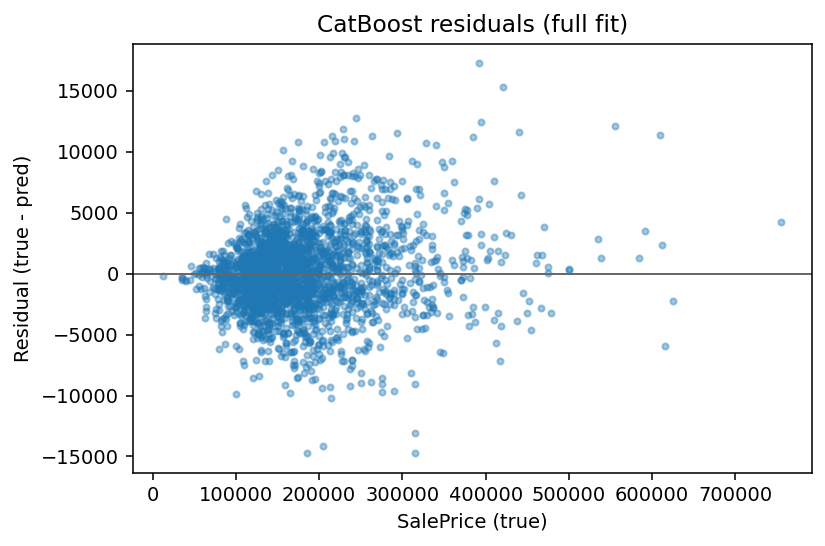

In [26]:
pd.set_option('future.no_silent_downcasting', True)
# --- 0) Your tuned CatBoost params
cb_best = dict(
    depth=5,
    iterations=3525,
    learning_rate=0.04646200613219409,
    l2_leaf_reg=2.79206264384178,
    subsample=0.7737417681056152,
    colsample_bylevel=0.8591483762431275,
    bagging_temperature=2.7192215619579607,
    random_strength=1.9079506260866257,
    min_data_in_leaf=185,
    loss_function="RMSE", random_state=42, verbose=0
)

# --- 1) Build pipeline (tree-friendly preprocessing + CatBoost)
cb_pipe = make_catboost_pipe(X_fe, **cb_best)

# --- 2) 5-fold CV on log-price; report RMSE ($), R² (OOF + full)
results = cv_eval_models(
    X=X_fe,
    y=y,
    models=[("CatBoost (tuned)", cb_pipe)],
    cv=5,
    random_state=42,
    log_target=True,       # log1p during fit, expm1 on predict
    show_progress=False
)
display(results)

# --- 3) Fit once on all data for final diagnostics
cb_pipe.fit(X_fe, np.log1p(y))
y_hat = np.expm1(cb_pipe.predict(X_fe))

# Metrics on full fit (for reference only—use CV for honesty)
from sklearn.metrics import r2_score, mean_squared_error
rmse_full = np.sqrt(mean_squared_error(y, y_hat))
r2_full   = r2_score(y, y_hat)
print(f"Full-fit RMSE: ${rmse_full:,.0f}  |  R²: {r2_full:.3f}")

# --- 4) Quick diagnostic table (OOF-style approximation via CV helper)
# If you want true OOF preds, re-run cv loop to capture them; here we just inspect residuals on full fit.
import pandas as pd
diag = pd.DataFrame({
    "y_true": y,
    "y_pred": y_hat,
    "residual": y - y_hat
})
print(diag.residual.describe().to_string())

# --- 5) Tiny residual plot to eyeball bias
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6,4), dpi=140)
plt.scatter(y, diag["residual"], s=10, alpha=0.4)
plt.axhline(0, color="#666", lw=1)
plt.xlabel("SalePrice (true)")
plt.ylabel("Residual (true - pred)")
plt.title("CatBoost residuals (full fit)")
plt.tight_layout()
plt.show()

In [27]:
best_cb_params = dict(
    depth=5,
    iterations=3525,
    learning_rate=0.04646200613219409,
    l2_leaf_reg=2.79206264384178,
    subsample=0.7737417681056152,
    colsample_bylevel=0.8591483762431275,
    bagging_temperature=2.7192215619579607,
    random_strength=1.9079506260866257,
    min_data_in_leaf=185,
    loss_function="RMSE", random_state=42, verbose=0
)
cb_pipe = make_catboost_pipe(X_fe, **best_cb_params)

In [28]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import pandas as pd

def get_oof_predictions(pipe, X, y, cv=5, random_state=42, log_target=True):
    """Return OOF predictions (in dollars), fold-by-fold metrics, and trained fold models."""
    kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    y_np = y.to_numpy() if hasattr(y, "to_numpy") else np.asarray(y, dtype=float)

    oof_pred = np.zeros(len(y_np), dtype=float)
    fold_models = []
    fold_metrics = []

    for tr_idx, va_idx in kf.split(X):
        X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr, y_va = y_np[tr_idx], y_np[va_idx]

        y_tr_fit = np.log1p(y_tr) if log_target else y_tr
        pipe_fold = make_catboost_pipe(X, **best_cb_params)  # fresh model each fold
        pipe_fold.fit(X_tr, y_tr_fit)

        pred = pipe_fold.predict(X_va)
        pred = np.expm1(pred) if log_target else pred  # back to dollars
        oof_pred[va_idx] = pred

        rmse = float(np.sqrt(mean_squared_error(y_va, pred)))
        r2   = float(r2_score(y_va, pred))
        fold_metrics.append({"rmse": rmse, "r2": r2})
        fold_models.append(pipe_fold)

    cv_rmse = float(np.mean([m["rmse"] for m in fold_metrics]))
    cv_r2   = float(np.mean([m["r2"]   for m in fold_metrics]))

    return oof_pred, fold_models, {"cv_rmse": cv_rmse, "cv_r2": cv_r2, "per_fold": fold_metrics}

# ---- run it
oof_pred, fold_models, cv_stats = get_oof_predictions(cb_pipe, X_fe, y, cv=5, random_state=42, log_target=True)

print(f"CV RMSE (OOF): {cv_stats['cv_rmse']:,.0f}")
print(f"CV R²   (OOF): {cv_stats['cv_r2']:.3f}")

CV RMSE (OOF): 19,095
CV R²   (OOF): 0.934


In [29]:
df_oof = X_fe.copy()
df_oof["_idx"]     = np.arange(len(df_oof), dtype=int)
df_oof["_id_"]     = df_oof.index              # or a stable id column if you have one
df_oof["y_true"]   = y.astype(float).to_numpy()
df_oof["oof_pred"] = oof_pred.astype(float)
df_oof["oof_resid"] = df_oof["y_true"] - df_oof["oof_pred"]  # <-- true OOF residuals

# For your later “underpriced pick” logic, create a compact base table:
candidates_base = df_oof.rename(columns={
    "oof_pred": "base_pred",
    "oof_resid": "residual"
})[["_idx","_id_","y_true","base_pred","residual"]]

candidates_base.head()

,_idx,_id_,y_true,base_pred,residual
1,0,1,126000.0,121409.042246,4590.957754
2,1,2,139500.0,131324.926155,8175.073845
3,2,3,124900.0,109630.051045,15269.948955
4,3,4,114000.0,103826.446075,10173.553925
5,4,5,227000.0,212453.921701,14546.078299


In [30]:
cb_final = make_catboost_pipe(X_fe, **best_cb_params)
cb_final.fit(X_fe, np.log1p(y))  # keep the same log-target convention

,steps,"[('prep', ...), ('reg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('elect', ...), ('num_log_cap', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


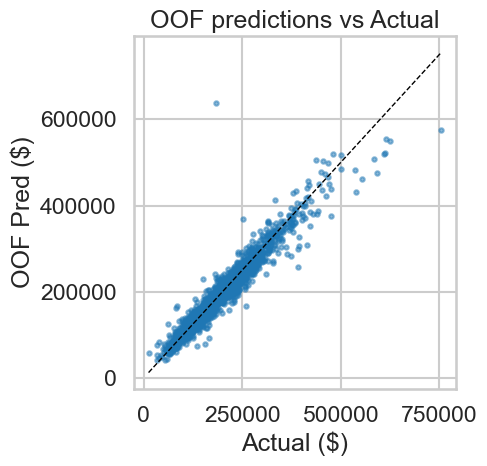

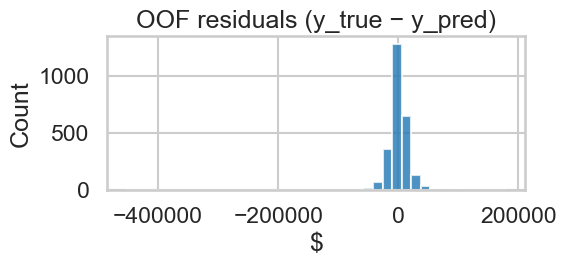

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(df_oof["y_true"], df_oof["oof_pred"], s=10, alpha=0.5)
lims = [min(df_oof["y_true"].min(), df_oof["oof_pred"].min()),
        max(df_oof["y_true"].max(), df_oof["oof_pred"].max())]
plt.plot(lims, lims, 'k--', lw=1)
plt.xlabel("Actual ($)"); plt.ylabel("OOF Pred ($)"); plt.title("OOF predictions vs Actual")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,3))
plt.hist(df_oof["oof_resid"], bins=40, alpha=0.8)
plt.title("OOF residuals (y_true − y_pred)"); plt.xlabel("$"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

In [34]:
# --- 1) Train/val split ---
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor

X_train, X_test, y_train, y_test = train_test_split(
    X_fe, y, test_size=0.2, random_state=42
)

# --- 2) Tell CatBoost which columns are categorical ---
cat_cols = X_fe.select_dtypes(include=['object', 'category']).columns.tolist()
cat_idx  = [X_train.columns.get_loc(c) for c in cat_cols]  # indices CatBoost expects

# (optional but safe) force cats to string dtype
for c in cat_cols:
    X_train[c] = X_train[c].astype(str)
    X_test[c]  = X_test[c].astype(str)

# --- 3) Fit CatBoost with your best param set (swap if you choose another) ---
cb_params = dict(
    depth=5,
    iterations=3525,
    learning_rate=0.04646200613219409,
    l2_leaf_reg=2.79206264384178,
    subsample=0.7737417681056152,
    colsample_bylevel=0.8591483762431275,
    bagging_temperature=2.7192215619579607,
    random_strength=1.9079506260866257,
    min_data_in_leaf=185,
    loss_function="RMSE",
    random_state=42,
    verbose=0
)

cb_final = CatBoostRegressor(**cb_params)
cb_final.fit(X_train, y_train, cat_features=cat_idx)

# --- 4) Predict + metrics ---
y_pred_test  = cb_final.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test   = r2_score(y_test, y_pred_test)
print(f"Test RMSE: {rmse_test:,.0f}  |  R²: {r2_test:.3f}")

Test RMSE: 18,858  |  R²: 0.942


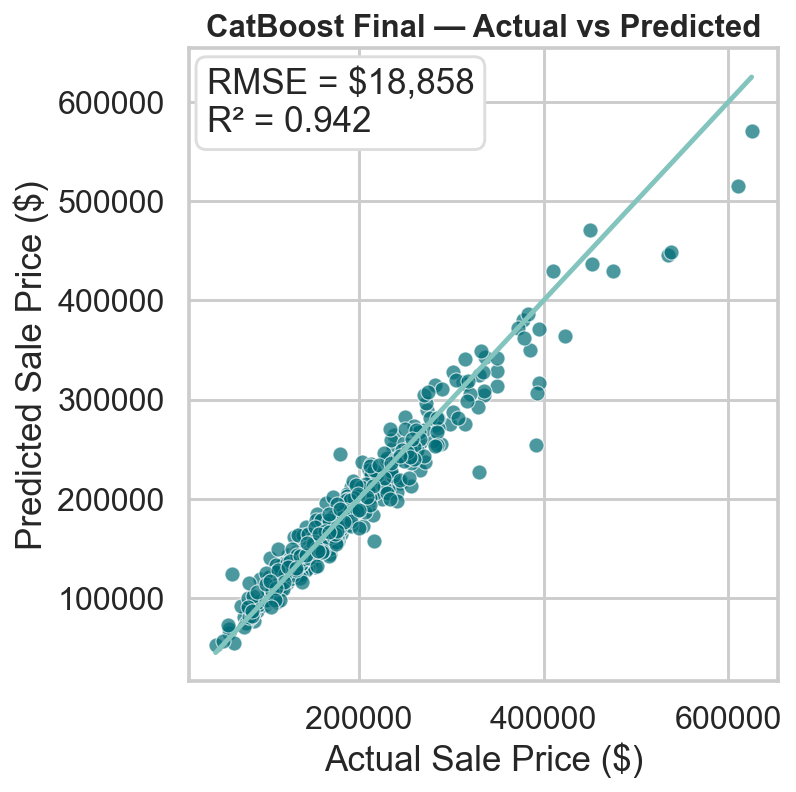

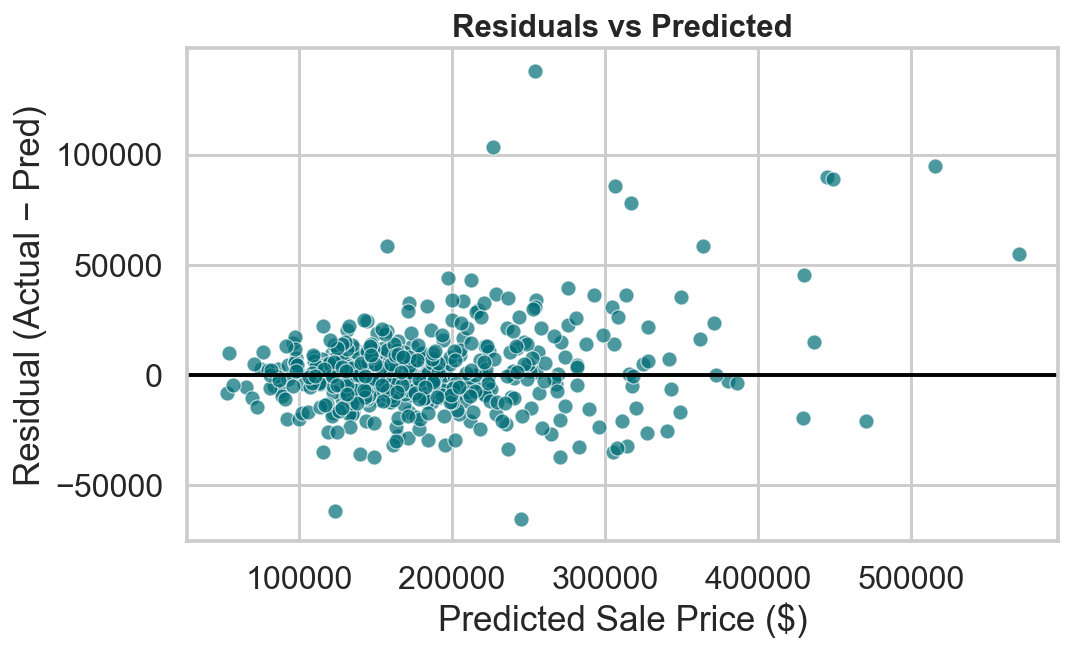

In [38]:
# Warwick colors
warwick_teal   = "#006d77"
warwick_accent = "#83c5be"

sns.set_style("whitegrid")
sns.set_context("talk")

# 1) Parity (Actual vs Predicted)
plt.figure(figsize=(6,6), dpi=140)
plt.scatter(y_test, y_pred_test, color=warwick_teal, alpha=0.7,
            edgecolor="white", linewidth=0.6, s=60)
lims = [min(y_test.min(), y_pred_test.min()), max(y_test.max(), y_pred_test.max())]
plt.plot(lims, lims, color=warwick_accent, lw=2.5)
plt.title("CatBoost Final — Actual vs Predicted", fontsize=16, weight="bold")
plt.xlabel("Actual Sale Price ($)")
plt.ylabel("Predicted Sale Price ($)")
# annotate metrics
plt.text(0.03, 0.97, f"RMSE = ${rmse_test:,.0f}\nR² = {r2_test:.3f}",
         transform=plt.gca().transAxes, va="top", ha="left",
         bbox=dict(facecolor="white", edgecolor="#ddd", boxstyle="round,pad=0.3"))
plt.tight_layout()
plt.show()

# 2) Residuals vs Predicted
residuals = y_test - y_pred_test
plt.figure(figsize=(8,5), dpi=140)
plt.scatter(y_pred_test, residuals, color=warwick_teal, alpha=0.7,
            edgecolor="white", linewidth=0.6, s=60)
plt.axhline(0, color="black", lw=2)
plt.title("Residuals vs Predicted", fontsize=16, weight="bold")
plt.xlabel("Predicted Sale Price ($)")
plt.ylabel("Residual (Actual − Pred)")
plt.tight_layout()
plt.show()